## Introducción

Este es el segundo notebook que acompaña al desarrollo del proyecto, siguiendo la linea de redacción de la memoria, esta sección se centra en la etapa sobre los modelos ML no supervisados.

- Importación de librerías

In [2]:
## Importación de librerías necesarias para este Notebook

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from scipy.stats import skew

from IPython.display import Audio

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import confusion_matrix

# Capítulo 3. Clasificador de sonidos de origen humano

En este notebook se realizan las pruebas con las técnicas mencionadas anteriormente con objetivo de validar y seleccionar un modelo adecuado para la tarea de clasificación.

## 3.2 Fase 1: Exploración de los datos y técnicas de agrupamiento.



### 3.2.1 Base de datos

Lo primero es cargar el dataset sobre el que se van a realizar las pruebas, ademas se realiza una visualización de la señal y su espectrograma y espectrograma de Mel.

In [3]:
data_path="..\\data"
filename="dataset_fase1.pkl"
filepath=os.path.join(data_path,filename)

dataset=pd.read_pickle(filepath)
sr=24000
signal=np.concatenate(dataset["Signal"])
sr=24000

In [4]:
print(len(dataset))

110


C:\Users\damardcv\AppData\Local\Temp\ipykernel_21100\74099312.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


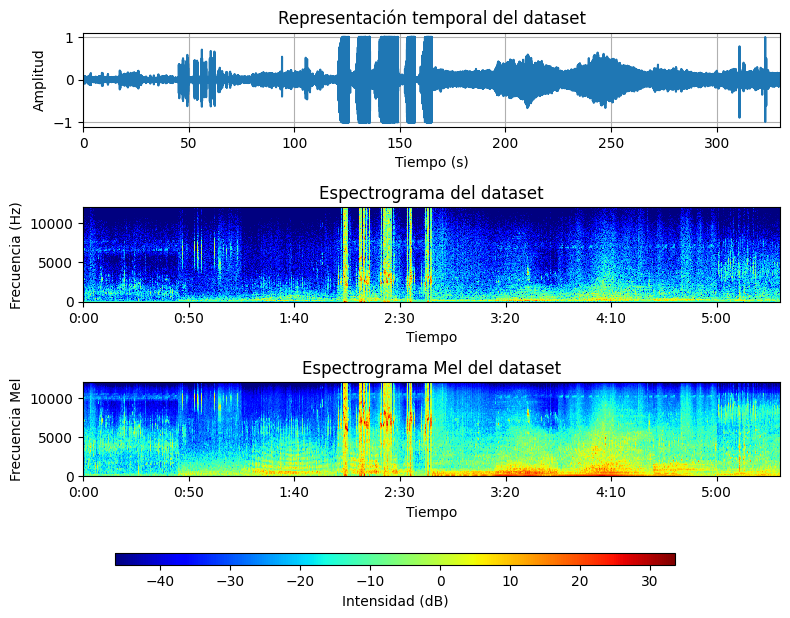

In [5]:
## Figura 22.
#Visualización de la señal, el espectrograma y el espectrograma Mel
times = np.linspace(0, len(signal) / sr, num=len(signal))

fig, axis = plt.subplots(3,1,figsize=(8,6))
axis[0].plot(times,signal)
axis[0].set_title("Representación temporal del dataset")
axis[0].set_xlabel("Tiempo (s)")
axis[0].set_ylabel("Amplitud")
axis[0].set_xlim([0,max(times)])
axis[0].grid()

n_fft = 2048
hop_length = 512
S = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(S))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="linear",cmap="jet",ax=axis[1])
axis[1].set_title("Espectrograma del dataset")
axis[1].set_xlabel("Tiempo")
axis[1].set_ylabel("Frecuencia (Hz)")

S_Mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft,hop_length=hop_length, n_mels=128)
S_Mel_dB = librosa.power_to_db(S_Mel)
img2=librosa.display.specshow(S_Mel_dB, sr=sr, x_axis="time", y_axis="linear",cmap="jet",ax=axis[2])
axis[2].set_title("Espectrograma Mel del dataset")
axis[2].set_xlabel("Tiempo")
axis[2].set_ylabel("Frecuencia Mel")

# Crear un nuevo axis para la colorbar horizontal
cbar_axis = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(img2, cax=cbar_axis, orientation="horizontal")
cbar.set_label("Intensidad (dB)")

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### 3.2.2 Caracteristicas

Se define una función que permita calcular las caracteristicas deseadas y montar una matriz de caracteristicas.

In [6]:
def feature_calc(audio_fragment, sr, features,N_mels,N_mfcc):
    # Función encargada de calcular las caracteristicas

    # Diccionario para mapear características a sus funciones de cálculo
    feature_funcs = {
        "spectral_flux": lambda y, sr: np.sqrt(np.sum(np.diff(np.abs(librosa.stft(y))**2, axis=1)**2, axis=0)),
        "spectral_centroid": lambda y, sr: librosa.feature.spectral_centroid(y=y, sr=sr),
        "spectral_bandwidth": lambda y, sr: librosa.feature.spectral_bandwidth(y=y, sr=sr),
        "spectral_rolloff": lambda y, sr: librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85),
        "spectral_contrast": lambda y, sr: librosa.feature.spectral_contrast(y=y, sr=sr),
        "spectral_flatness": lambda y, sr: librosa.feature.spectral_flatness(y=y),
        "spectral_skewness": lambda y, sr: skew((np.fft.fftfreq(np.abs(librosa.stft(y)).shape[0], d=1/sr)[:, np.newaxis] -
                                                 librosa.feature.spectral_centroid(y=y, sr=sr)) /
                                                librosa.feature.spectral_bandwidth(y=y, sr=sr) *
                                                np.abs(librosa.stft(y))**2, axis=0, bias=False, nan_policy='omit'),
        "mfcc": lambda y, sr: librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_mfcc),
        "delta_mfcc": lambda y, sr: librosa.feature.delta(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_mfcc))
    }

    # Calcular las características especificadas
    calculated_features = {}
    for feature in features:
        calculated_features[feature] = feature_funcs[feature](audio_fragment, sr)

    # Calcular estadísticas
    sample_features = []
    for feature, values in calculated_features.items():
        if feature in ["mfcc", "delta_mfcc"]:  # Para MFCC y Delta MFCC, calcular estadísticas por coeficiente
            mean = values.mean(axis=1).tolist()
            std = values.std(axis=1).tolist()
        else:  # Para otras características, calcular estadísticas directamente
            mean = values.mean()
            std = values.std()

        sample_features.extend(mean if isinstance(mean, list) else [mean])
        sample_features.extend(std if isinstance(std, list) else [std])

    return sample_features


def feature_extract(df_dataset, sr, features,n_mels=128,n_mfcc=13):
    # Función encargada preparar el dataframe de caracteristicas y de solicitarlas
    columns = [] # Columna que contendrá los nombres
    # Generar nombres de columnas según las caracteristicas solicitadas
    for feature in features:
        if feature in ["mfcc", "delta_mfcc"]:
            columns.extend([f"{feature}_mean_{i}" for i in range(n_mfcc)])
            columns.extend([f"{feature}_std_{i}" for i in range(n_mfcc)])
        else:
            columns.append(f"{feature}_mean")
            columns.append(f"{feature}_std")

    df_features = pd.DataFrame(columns=columns)

    for index, row in df_dataset.iterrows():
        # Para cada muestra obtenemos las caracteristicas
        audio_fragment=row["Signal"]
        caracteristicas = feature_calc(audio_fragment, sr, features,n_mels,n_mfcc)
        df_features.loc[index] = caracteristicas

    return df_features

Se escogen las características a calcular, es posible comentar o eliminar la característica que no se quiera obtener de la lista.

In [7]:
#
features = [
    # "spectral_flux",
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_rolloff",
    "spectral_contrast",
    # "spectral_flatness",
    "spectral_skewness",
    "mfcc",
    # "delta_mfcc"
]
df_features=feature_extract(dataset, sr, features,n_mels=128,n_mfcc=20)


Para el análisis del impacto de las caracteristicas se define una función de apoyo que nos permita representar de forma agil el histograma de las caracteristicas indicando su índice en la tabla "df_features"

In [8]:
# Función de apoyo para visualizar los histogramas
def plot_feature_histograms(df_features):
    num_features = len(df_features.columns)
    num_rows = (num_features) // 2

    fig, axes = plt.subplots(num_rows, 2, figsize=(8, num_rows * 2))
    axes = axes.flatten()  # Aplanar para facilitar el acceso a los ejes

    for i, column in enumerate(df_features.columns):
        axes[i].hist(df_features[column], bins=30, color="blue", alpha=0.7)
        axes[i].set_title(f"Histograma de {column}")
        axes[i].set_xlabel("Valor")
        axes[i].set_ylabel("Frecuencia")

    # Si hay gráficos sin usar, los ocultamos
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


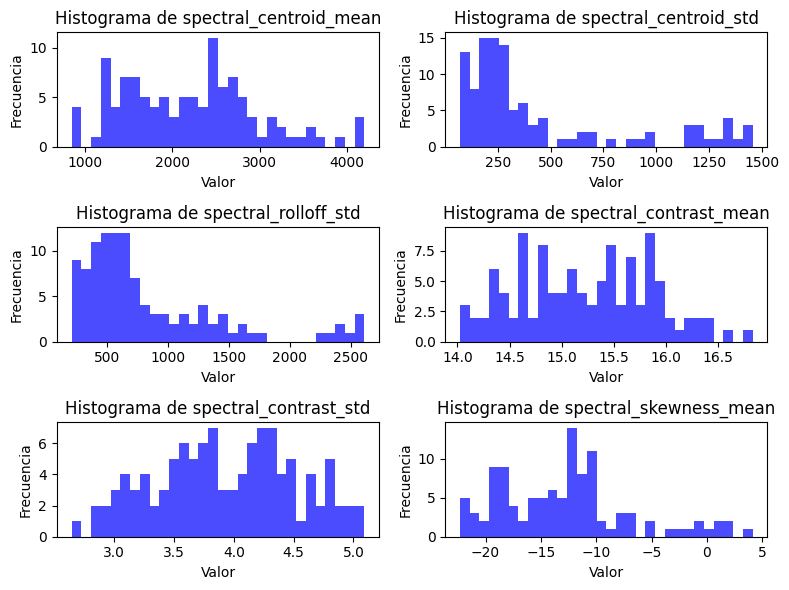

In [9]:
filt_columns=df_features.columns[[0,1,5,6,7,8]] # Para filtrar las columnas y solo mostrar los histogramas deseados
plot_feature_histograms(df_features[filt_columns])

Una vez obtenidas las caracteristicas deseadas se procede al escalado o normalización de los datos. Para ello se utiliza el StandardScaler.

In [10]:
# Escalado de datos previo al ML
scaler = StandardScaler()
X = scaler.fit_transform(df_features)
df_X=pd.DataFrame(X,columns=df_features.columns)
print(df_X.shape)
print(X.min(),X.max())
df_X.head() # Para ver los valores en formato DataFrame

(110, 50)
-3.4426486804993615 4.606224506977578


spectral_centroid_mean  spectral_centroid_std  spectral_bandwidth_mean  \
0                0.718230              -0.279091                 0.768460   
1                1.410092               0.035783                 1.261257   
2                0.936906              -0.362328                 0.648028   
3                0.406151              -0.458453                 0.352286   
4                0.348316              -0.441983                 0.714395   

   spectral_bandwidth_std  spectral_rolloff_mean  spectral_rolloff_std  \
0               -0.685014               1.075530             -0.482377   
1               -0.417878               1.406348             -0.381843   
2                0.433361               1.009793              0.053791   
3                0.186172               0.661262              0.568450   
4               -0.015469               0.832772              0.259685   

   spectral_contrast_mean  spectral_contrast_std  spectral_skewness_mean  \
0               -0.261128               0.276058                0.397902   
1               -0.623201              -0.320152                0.289441   
2                0.921583               1.240396                0.977597   
3                1.165087               0.884183                0.763565   
4                1.906826               1.497476                0.258767   

   spectral_skewness_std  ...  mfcc_std_10  mfcc_std_11  mfcc_std_12  \
0               0.247276  ...     0.647473    -0.355666    -0.075431   
1              -0.570732  ...     1.326620     0.269465    -0.724740   
2               2.019062  ...     1.894022     1.048143     1.107067   
3               1.636962  ...     1.490163     0.229300     1.979561   
4               0.849773  ...    -0.078345     0.898759     0.200751   

   mfcc_std_13  mfcc_std_14  mfcc_std_15  mfcc_std_16  mfcc_std_17  \
0     0.243614    -0.525125     0.173775    -0.126988    -0.129660   
1     0.336774    -0.005102    -0.724742     0.188142    -0.041839   
2    -0.163375     0.134519     0.372004     0.749651     1.114942   
3     0.478911     1.022632     1.695192     1.021151     3.007276   
4     0.652013     0.974164    -0.476792     1.136043     0.437961   

   mfcc_std_18  mfcc_std_19  
0    -0.202386    -0.036406  
1    -0.080119    -0.432194  
2     0.593795     0.884875  
3     0.341170     0.692956  
4    -0.562220     0.643969  

[5 rows x 50 columns]

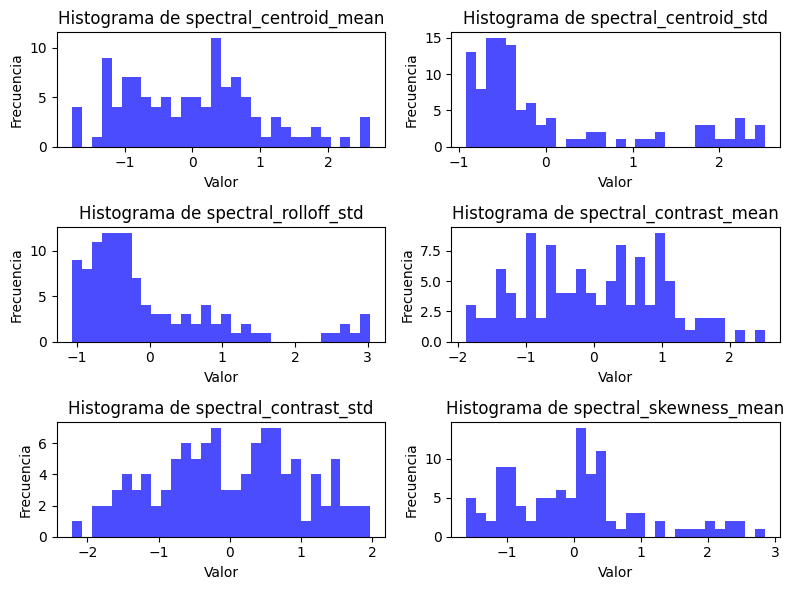

In [28]:
## Figuras 23,24,25
# Se visualizan los histogramas de nuevo, de esta forma se puede apreciar que mantiene la forma de los datos pero esta vez normalizado
filt_columns=df_X.columns[[0,1,5,6,7,8]] # Para filtrar las columnas y solo mostrar los histogramas deseados
plot_feature_histograms(df_X[filt_columns])

#### 3.2.3 Seleccion de modelos

**Reducción de dimensionalidad**

Ajuste de PCA y obtención del número de componentes óptimos (>95% varianza explicada)

Número de componentes para explicar el 95% de la varianza: 21


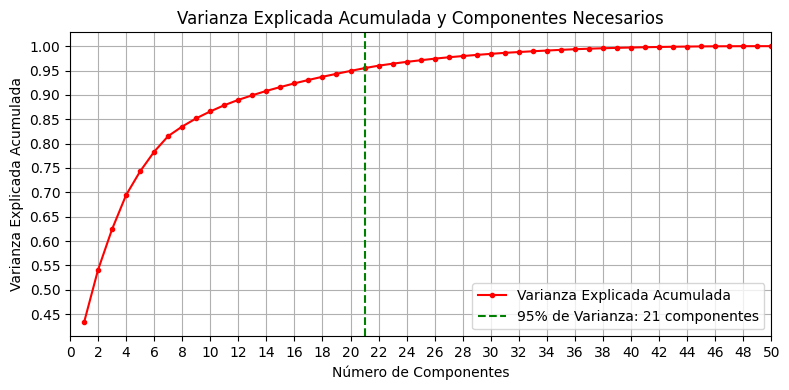

In [12]:
## Figura 26.

# Ajustar PCA y calcular el n_componentes óptimo
pca = PCA().fit(X)

# Varianza explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Calcular el número de componentes necesarios para alcanzar cada nivel acumulado de varianza
components_needed = np.arange(1, len(cumulative_variance) + 1)

# Crear la figura y el axis
plt.figure(figsize=(8, 4))
plt.plot(components_needed, cumulative_variance, marker=".", color="r", label="Varianza Explicada Acumulada")

# Añadir una línea vertical para el 95% de la varianza
n_components = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(n_components, color="g", linestyle="--", label=f"95% de Varianza: {n_components} componentes")
print(f"Número de componentes para explicar el 95% de la varianza: {n_components}")

plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada Acumulada y Componentes Necesarios")
plt.xlim(0,50)
plt.xticks([com for com in range(0,51,2)])
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
plt.grid()
plt.legend(loc="best")

plt.tight_layout()
plt.show()


Proyección de las 2 primeras componentes para la visualización en 2D

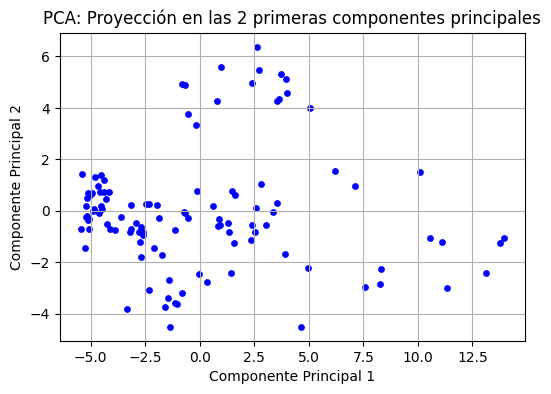

In [13]:
## Figura 27.
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X)

# Visualizar las dos primeras componentes principales
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c="blue",s=15)
plt.title("PCA: Proyección en las 2 primeras componentes principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()

**Clustering**

* **KMEANS**

Método del codo para elección de k.




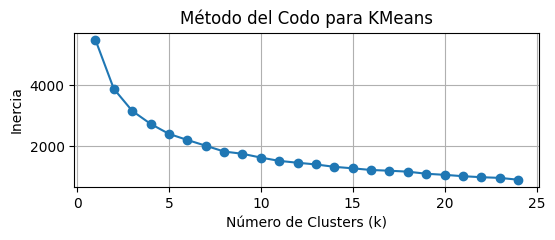

In [14]:
## Figura 28.
inertia = []
for i in range(1, 25):
  kmeans = KMeans(n_clusters=i, random_state=42,n_init=10)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(6, 2))
plt.plot(range(1, 25), inertia, marker="o")
plt.title("Método del Codo para KMeans")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.grid()
plt.show()

Aplicación del modelo K-Means para diferente numero de clústers

In [15]:
# Aplicación de Kmeans con 3 a 8 clusters
kmeans_model_k3=KMeans(n_clusters=3, random_state=5,n_init=10).fit(X_pca)
kmeans_model_k4=KMeans(n_clusters=4, random_state=5,n_init=10).fit(X_pca)
kmeans_model_k5=KMeans(n_clusters=5, random_state=5,n_init=10).fit(X_pca)
kmeans_model_k6=KMeans(n_clusters=6, random_state=5,n_init=10).fit(X_pca)
kmeans_model_k7=KMeans(n_clusters=7, random_state=5,n_init=10).fit(X_pca)
kmeans_model_k8=KMeans(n_clusters=8, random_state=5,n_init=10).fit(X_pca)


df_labels=pd.DataFrame({
    "Kmeans k=3" : kmeans_model_k3.labels_,
    "Kmeans k=4" : kmeans_model_k4.labels_,
    "Kmeans k=5" : kmeans_model_k5.labels_,
    "Kmeans k=6" : kmeans_model_k6.labels_,
    "Kmeans k=7" : kmeans_model_k7.labels_,
    "Kmeans k=8" : kmeans_model_k8.labels_
})

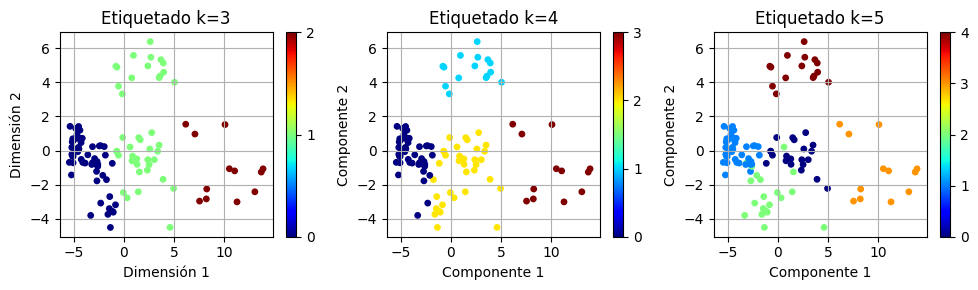

In [16]:
## Figura 29.
fig, axis = plt.subplots(1,3,figsize=(10,3))
scatter1=axis[0].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k3.labels_,cmap="jet",s=15)
axis[0].set_title("Etiquetado k=3")
axis[0].set_xlabel("Dimensión 1")
axis[0].set_ylabel("Dimensión 2")
colorbar1 = plt.colorbar(scatter1, ax=axis[0])
colorbar1.set_ticks(range(len(set(kmeans_model_k3.labels_))))
axis[0].grid(True)
scatter2=axis[1].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k4.labels_,cmap="jet",s=15)
axis[1].set_title("Etiquetado k=4")
axis[1].set_xlabel("Componente 1")
axis[1].set_ylabel("Componente 2")
colorbar2 = plt.colorbar(scatter2, ax=axis[1])
colorbar2.set_ticks(range(len(set(kmeans_model_k4.labels_))))
axis[1].grid(True)
scatter3=axis[2].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k5.labels_,cmap="jet",s=15)
axis[2].set_title("Etiquetado k=5")
axis[2].set_xlabel("Componente 1")
axis[2].set_ylabel("Componente 2")
colorbar3 = plt.colorbar(scatter3, ax=axis[2])
colorbar3.set_ticks(range(len(set(kmeans_model_k5.labels_))))
axis[2].grid(True)
plt.tight_layout()
plt.show()

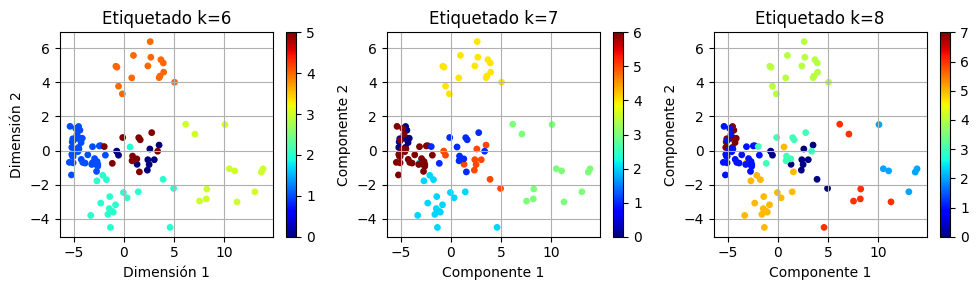

In [17]:
## Figura 30.
fig, axis = plt.subplots(1,3,figsize=(10,3))
scatter1=axis[0].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k6.labels_,cmap="jet",s=15)
axis[0].set_title("Etiquetado k=6")
axis[0].set_xlabel("Dimensión 1")
axis[0].set_ylabel("Dimensión 2")
colorbar1 = plt.colorbar(scatter1, ax=axis[0])
axis[0].grid(True)
scatter2=axis[1].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k7.labels_,cmap="jet",s=15)
axis[1].set_title("Etiquetado k=7")
axis[1].set_xlabel("Componente 1")
axis[1].set_ylabel("Componente 2")
colorbar2 = plt.colorbar(scatter2, ax=axis[1])
axis[1].grid(True)
scatter3=axis[2].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k8.labels_,cmap="jet",s=15)
axis[2].set_title("Etiquetado k=8")
axis[2].set_xlabel("Componente 1")
axis[2].set_ylabel("Componente 2")
colorbar2 = plt.colorbar(scatter3, ax=axis[2])
axis[2].grid(True)

plt.tight_layout()
plt.show()

In [18]:
## Tabla 2.
# Crear un vector con la cantidad de muestras por cada uno de los fragmentos que componen el dataset.

frag1=[4 for x in range(15)]
frag2=[0 for x in range(10)]
frag3=[2 for x in range(15)]
frag4=[3 for x in range(15)]
frag5=[1 for x in range(10)]
frag6=[1 for x in range(10)]
frag7=[1 for x in range(15)]
frag8=[1 for x in range(10)]
frag9=[5 for x in range(10)]

manual_labels=frag1+frag2+frag3+frag4+frag5+frag6+frag7+frag8+frag9

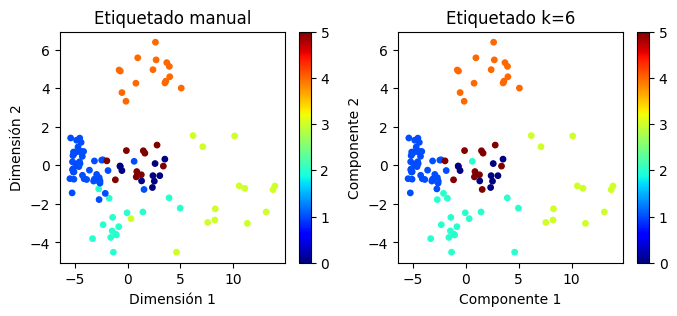

In [29]:

import seaborn as sns
## Figura 31.
fig, axis = plt.subplots(1,2,figsize=(8,3))
scatter1=axis[0].scatter(X_pca[:, 0], X_pca[:, 1],c=manual_labels,cmap="jet",s=15)
axis[0].set_title("Etiquetado manual")
axis[0].set_xlabel("Dimensión 1")
axis[0].set_ylabel("Dimensión 2")
colorbar1 = plt.colorbar(scatter1, ax=axis[0])

scatter2=axis[1].scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans_model_k6.labels_,cmap="jet",s=15)
axis[1].set_title("Etiquetado k=6")
axis[1].set_xlabel("Componente 1")
axis[1].set_ylabel("Componente 2")
colorbar2 = plt.colorbar(scatter2, ax=axis[1])

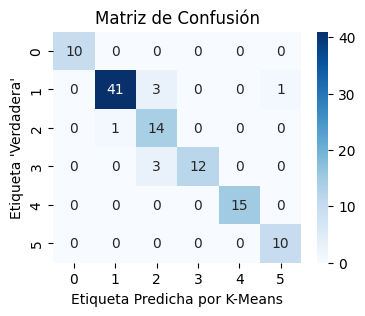

In [20]:
## Figura 32.
# Crear y visualizar la matriz de confusión
conf_matrix = confusion_matrix(manual_labels, kmeans_model_k6.labels_)

# Mostrar la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha por K-Means")
plt.ylabel("Etiqueta 'Verdadera'")
plt.show()

DBSCAN

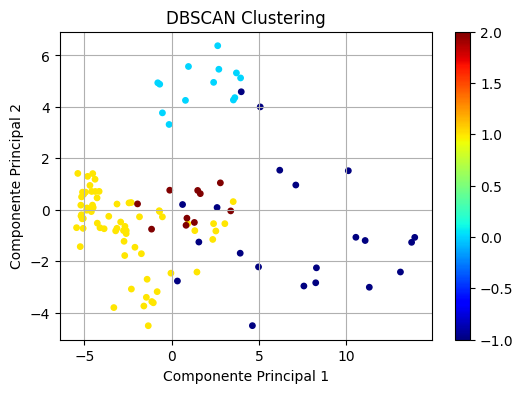

In [22]:
## Figura 33.
# Ajustar DBSCAN al conjunto de datos
dbscan = DBSCAN(eps=5, min_samples=5)  # Ajusta eps y min_samples según sea necesario
labels = dbscan.fit_predict(X_pca)

# Visualizar los resultados
plt.figure(figsize=(6, 4))
scatter1=plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='jet', s=15)
plt.title('DBSCAN Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
colorbar1 = plt.colorbar(scatter1)
plt.grid()
plt.show()


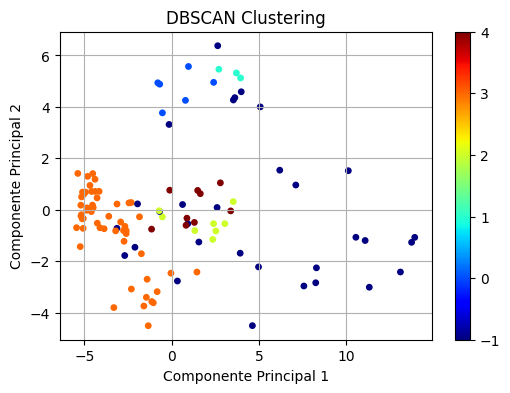

In [23]:
## Figura 34.
# Ajustar DBSCAN al conjunto de datos
dbscan = DBSCAN(eps=4, min_samples=5)  # Ajusta eps y min_samples según sea necesario
labels = dbscan.fit_predict(X_pca)

# Visualizar los resultados
plt.figure(figsize=(6, 4))
scatter1=plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='jet', s=15)
plt.title('DBSCAN Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
colorbar1 = plt.colorbar(scatter1)
plt.grid()
plt.show()

------------------------

* Pruebas adicionales de reproducción de los audios agrupados por etiqueta

In [24]:
## Para reproducir las diferentes etiquetas lo asignamos a dataset
dataset["Kmeans k=3"]=kmeans_model_k3.labels_
dataset["Kmeans k=4"]=kmeans_model_k4.labels_
dataset["Kmeans k=5"]=kmeans_model_k5.labels_
dataset["Kmeans k=6"]=kmeans_model_k6.labels_
dataset["Kmeans k=7"]=kmeans_model_k7.labels_
dataset["Kmeans k=8"]=kmeans_model_k8.labels_
dataset["Generic Label"]= manual_labels

In [34]:
df_tests_kmeans=dataset[dataset["Kmeans k=6"]==4].reset_index(drop=True)
mix_signals=np.concatenate(df_tests_kmeans["Signal"])
Audio(data=mix_signals,rate=sr)

In [33]:
df_tests_generic=dataset[dataset["Generic Label"]==4].reset_index(drop=True)
mix_signals=np.concatenate(df_tests_generic["Signal"])
Audio(data=mix_signals,rate=sr)

In [39]:
## Funciones de apoyo para visualización y audición

def visual_five_fragments(i,training_data):
    print(f"Muestras {i*5}-{i*5+4} de {len(training_data)-1}. Max i: {len(training_data)/5-1}")
    n_fft = 1024
    hop_length = 512

    _,axis=plt.subplots(2,5,figsize=(10,3))

    for iter in range(5):
        index=i*5+iter
        y_fragment=training_data["Signal"][index]

        S_Mel = librosa.feature.melspectrogram(y=y_fragment, sr=sr, n_fft=n_fft,hop_length=hop_length, n_mels=128)
        S_Mel_dB = librosa.power_to_db(S_Mel)

        t_seg=len(y_fragment)/sr
        n=len(y_fragment)
        x=np.linspace(0,t_seg,n)

        axis[0,iter].plot(x,y_fragment)
        axis[0,iter].set_ylim([-1,1])
        axis[0,iter].set_xlim([0,3])
        axis[0,iter].grid()
        librosa.display.specshow(S_Mel_dB, sr=sr, x_axis="time", y_axis="linear",cmap="jet",ax=axis[1,iter])
        Lk6=training_data["Kmeans k=6"][index]
        Lgen=training_data["Generic Label"][index]
        axis[0,iter].set_title(f"Sample {index}, Label {Lgen}-{Lk6}")
    plt.tight_layout()


def play_fragment(sub_i,training_data):
    sound=training_data["Signal"][sub_i]
    return Audio(data=sound,rate=sr)

Muestras 35-39 de 109. Max i: 21.0


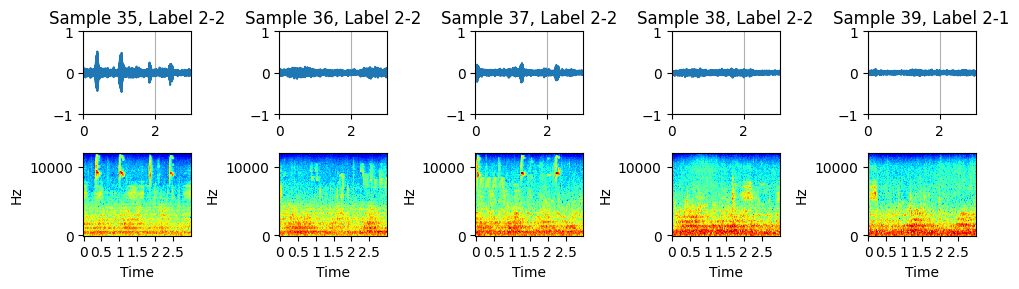

In [52]:
i=7
visual_five_fragments(i,dataset)

In [54]:
play_fragment(38,dataset)